# Load dataset

In [16]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

import pdb

import pandas as pd

In [17]:
import skimage.io as io
from skimage.transform import rescale

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms

In [19]:
def get_vietnamese_alphabets(is_include_space=False):
    lower_vowels_with_dm = u'áàảãạắằẳãặâấầẩẫậíìỉĩịúùủũụưứừửữựéèẻẽẹêếềểễệóòỏõọơớờởỡợôốồổỗộyýỳỷỹỵ'
    upper_vowels_with_dm = lower_vowels_with_dm.upper()
    lower_without_dm = u'abcdefghijklmnopqrstuvwxyzđ'
    upper_without_dm = lower_without_dm.upper()
    digits = '1234567890'
    
    if is_include_space:
        symbols = '?/*+-!,."\':;#%&()[] ' # including space character ' ' is using for line recognition only 
    else:
        symbols = '?/*+-!,."\':;#%&()[]' # including space character ' ' is using for line recognition only
    alphabets = lower_vowels_with_dm + lower_without_dm + upper_vowels_with_dm + upper_without_dm + digits + symbols
    return alphabets

In [20]:
class LabelEncoderDecoder:
    """
    Encode a string to one hot vectors and vice versa
    """
    def __init__(self, alphabets=None, eos_char=None, is_include_space=False):
        
        self.alphabets = alphabets or get_vietnamese_alphabets(is_include_space)
        self.eos_char = eos_char or '\n'    
        
        self.alphabets = self.alphabets + self.eos_char
        self.char_to_int = dict((c, i) for i, c in enumerate(self.alphabets))
        self.int_to_char = dict((i, c) for i, c in enumerate(self.alphabets))

    def encode(self, string):
        """
        Encode a string to one hot vector using alphabets
        """
        encoded_vectors = []
        for char in string:
            vector = [0]*len(self.alphabets)
            vector[self.char_to_int[char]] = 1
            encoded_vectors.append(vector)
        return np.array(encoded_vectors, dtype=int)

    def decode(self, vectors):
        string = ''.join(self.int_to_char[np.argmax(vector)] for vector in vectors)
        string = string.replace(self.eos_char, '')
        return string
    
label_encoder_decoder = LabelEncoderDecoder(get_vietnamese_alphabets(is_include_space=False), eos_char='\n', is_include_space=False)

In [21]:
# TODO: this is temporal for now, because line-level has less files than word-level, thus load faster.
img_train_folder = './data/VNOnDB/line_train/'
img_val_folder = './data/VNOnDB/line_val/'
img_test_folder = './data/VNOnDB/line_test/'
# train_folder = './dataset/VNOnDB/word_train/'
# val_folder = './dataset/VNOnDB/word_val/'
# test_folder = './dataset/VNOnDB/word_test/'

In [22]:
class VNOnDBDataset(Dataset):
    def __init__(self, root_dir, dataframe, transform=None):
        self.root_dir = root_dir
        
        self.df = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        image_path = os.path.join(self.root_dir, self.df['id'][idx]+'.png')
        image = io.imread(image_path)
        
        if self.transform:
            image = self.transform(image)
        
        label = self.df['label'][idx]
        label = label + label_encoder_decoder.eos_char
        label = label_encoder_decoder.encode(label)
            
        return image, label

In [23]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 48)),
#     transforms.Resize((8, 12)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

66991
torch.Size([1, 32, 48]) (5, 216)


'đáng'

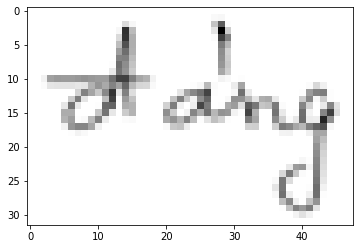

In [24]:
# TEST
mode = 'train'
level = 'word'

df = pd.read_csv(f'./data/VNOnDB/{mode}_{level}.csv', sep='\t', index_col=0)
print(len(df))
dataset = VNOnDBDataset(f'./data/VNOnDB/{level}_{mode}', df, transform)

X, y = dataset[803]
# plt.rcParams['figure.figsize'] = (2,1)
plt.imshow(torch.squeeze(X), cmap='gray')
print(X.shape, y.shape)
label_encoder_decoder.decode(y)

In [25]:
max_length = df['label'].astype(str).map(len).max()
max_length

11

# Define model

In [26]:
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.norm1 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)
        self.norm2 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv7 = nn.Conv2d(512, 512, 3, padding=1)
        self.norm3 = nn.BatchNorm2d(512)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.norm1(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.norm2(F.relu(self.conv5(x)))
        x = F.relu(self.conv6(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.norm3(F.relu(self.conv7(x)))
        x = F.dropout2d(x)
        
        return x

In [61]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, batch_size, hidden_size, bidirectional=True):
        super(EncoderRNN, self).__init__()
        
        self.bidirectional = bidirectional
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        
        self.cnn = CNNNet()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, bidirectional=bidirectional)    
        
    def init_hidden(self):
        return (torch.zeros(1 + int(self.bidirectional), self.batch_size, self.hidden_size),
                torch.zeros(1 + int(self.bidirectional), self.batch_size, self.hidden_size))
    
    def forward(self, x, hidden):
        # x is an image, shape (batch_size, 1, 32, 48), TODO: currently, batchsize = 1
#         pdb.set_trace()
        x = self.cnn(x)
#     torch.Size([3, 512, 2, 3])
        x = torch.sum(x, dim=2) # merge two row by summing
#     torch.Size([3, 512, 3])
        x = x.permute(2, 0, 1)
#     torch.Size([3, 3, 512])
        output, hidden = self.lstm(x, hidden)
        return output, hidden

In [62]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, vocab_size):
        super(AttnDecoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.attn = nn.Linear(hidden_size + output_size, 1)
        self.lstm = nn.LSTM(hidden_size + vocab_size, output_size)
        self.final = nn.Linear(output_size, vocab_size)
        
    def init_hidden(self):
        return (torch.zeros(1,1,self.output_size),
                torch.zeros(1,1,self.output_size))
        
    def forward(self, x, decoder_hidden, encoder_outputs):
        weights = []
        for i in range(len(encoder_outputs)):
            print(s_t[0][0].shape)
            print(h_i[0].shape)
            weights.append(self.attn(torch.cat((decoder_hidden[0][0], 
                                              encoder_outputs[i]), dim = 1)))
        normalized_weights = F.softmax(torch.cat(weights, 1), 1)

        attn_applied = torch.bmm(normalized_weights.unsqueeze(1),
                                 encoder_outputs.view(1, -1, self.hidden_size))

        input_lstm = torch.cat((attn_applied[0], input[0]), dim = 1) #if we are using embedding, use embedding of input here instead

        output, hidden = self.lstm(input_lstm.unsqueeze(0), decoder_hidden)

        output = self.final(output[0])

        return output, hidden, normalized_weights

# Training

In [63]:
batch_size = 8
input_size = 512
encoder_hidden_size = 256
decoder_hidden_size = 512
seq_lens = 256 # TODO: = max len of all sequencs in dataset
vocab_size = len(label_encoder_decoder.alphabets)

learning_rate = 0.01

In [64]:
encoder = EncoderRNN(input_size, batch_size, encoder_hidden_size)
decoder = AttnDecoderRNN(decoder_hidden_size, seq_lens, vocab_size)

# encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
# decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
# criterion = nn.CrossEntropyLoss()

In [65]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cpu')

In [66]:
# def train(input_tensor, target_tensor, cnn, encoder, decoder, encoder_optim, decoder_optim, criterion, max_length):


In [67]:
def batchize_labels(list_samples):
    list_image_sample = [sample[0] for sample in list_samples]
    list_label_sample = [torch.tensor(sample[1]) for sample in list_samples]
    
    batch_images = torch.stack(list_image_sample)
    batch_labels = torch.nn.utils.rnn.pad_sequence(list_label_sample)
    return batch_images, batch_labels

In [68]:
train_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=batchize_labels)

In [69]:
loader_iter = iter(train_loader)

In [70]:
batch_X, batch_y = next(loader_iter)
print(batch_X.shape, batch_y.shape)

torch.Size([8, 1, 32, 48]) torch.Size([6, 8, 216])


In [ ]:
eacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.init_hidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length